# Understanding School Performance on Pennsylvania Standardized Tests

## Extended Modeling - Part 1

The solution space for extended modeling for each of our two models (ELA performance and Math performance) is as follows:

- 2 different design matrices
    - One with all original features
    - Another with highly correlated features removed


- 3 regression algorithms:
    - Random Forest
    - LightGBM
    - XGBoost
    
This will give us 6 models to compare for each of our two target variables. When training the models, we will apply hyperparameter tuning to the algorithms to attempt to minimize the mean absolute error.

### Contents

- [1 - Import packages and load data](#section1)
- [2 - Final preparation for modeling](#section2)
- [3 - Models for School Performance in ELA](#section3)
  - [3.1 - All original features](#section3.1)
    - [3.1.1 - Random Forest](#section3.1.1)
    - [3.1.2 - LightGBM](#section3.1.2)
    - [3.1.3 - XGBoost](#section3.1.3)
  - [3.2 - High correlation features removed](#section3.2)
    - [3.2.1 - Random Forest](#section3.2.1)
    - [3.2.2 - LightGBM](#section3.2.2)
    - [3.2.3 - XGBoost](#section3.2.3)

- [4 - Models for School Performance in Math](#section4)
  - [4.1 - All original features](#section4.1)
    - [4.1.1 - Random Forest](#section4.1.1)
    - [4.1.2 - LightGBM](#section4.1.2)
    - [4.1.3 - XGBoost](#section4.1.3)

  - [4.2 - High correlation features removed](#section4.2)
    - [4.2.1 - Random Forest](#section4.2.1)
    - [4.2.2 - LightGBM](#section4.2.2)
    - [4.2.3 - XGBoost](#section4.2.3)

- [5 - Model Selection](#section5)
  - [5.1 - ELA Model Selection](#section5.1)
  - [5.2 - Math Model Selection](#section5.2)

- [6 - Feature Impact](#section6)
  - [6.1 - ELA School Performance Model](#section6.1)
  - [6.2 - Math School Performance Model](#section6.2)
  - [6.3 - Feature Impact Considerations](#section6.3)
  
- [7 - Next steps](#section7)


<a id='section1'></a>
## 1. Import packages and load data

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
# load data
X_train = pd.read_csv('../Data/X_train_scaled.csv', index_col = 0)
X_test = pd.read_csv('../Data/X_test_scaled.csv', index_col = 0)

ELA_train = pd.read_csv('../Data/y_train_ELA.csv', index_col = 0)
ELA_test = pd.read_csv('../Data/y_test_ELA.csv', index_col = 0)

math_train = pd.read_csv('../Data/y_train_math.csv', index_col = 0)
math_test = pd.read_csv('../Data/y_test_math.csv', index_col = 0)

In [3]:
# load metrics dataframe
metrics = pd.read_csv('../Data/metrics.csv', index_col = 0)
metrics

,Subject,Features,Algorithm,Train r2,Train MAE,Train 95% Worst Case Error LB,Train 95% Worst Case Error UB,Test r2,Test MAE,Test 95% Worst Case Error LB,Test 95% Worst Case Error UB
0,ELA,All features,Linear Regression (baseline),0.799005,6.677475,-16.547091,17.187611,0.771052,6.948462,-18.039068,17.495580
1,Math,All features,Linear Regression (baseline),0.700370,9.679650,-22.831911,24.116995,0.655321,10.117124,-24.413786,23.483108


In [4]:
# load highly correlated features list

open_file = open('../Data/corr_features.pkl', "rb")
corr_features = pickle.load(open_file)
open_file.close()

corr_features

['Female (School)',
 'Total Federal Expenditure',
 'English Learner',
 'White',
 'Total Personnel Expenditure',
 'Total State Expenditure',
 'Total Expenditure',
 'Total Non-Personnel Expenditure',
 'Total Local Expenditure']

<a id='section2'></a>
## 2. Final preparation for modeling

As mentioned in our plan for extended modeling above, we will take our X_train and X_test dataframes and remove the highly correlated features from them to create new dataframes.  We'll call these X_train2 and X_test2.  

Then we will convert all of these, including our target vectors into numpy arrays.

In [5]:
# drop highly correlated features to create new dataframes
X_train2 = X_train.drop(corr_features, axis = 1)
X_test2 = X_test.drop(corr_features, axis = 1)

We'll ensure that the correct number of features were dropped.

In [6]:
print(len(corr_features) == len(X_train.columns) - len(X_train2.columns))
print(len(corr_features) == len(X_test.columns) - len(X_test2.columns))

True
True


We'll save the column labels prior to converting to numpy arrays.

In [7]:
cols = X_train.columns
cols2 = X_train2.columns

We'll also convert all of our pandas objects into numpy arrays.

In [8]:
# convert datasets with all original features
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

# convert datasets with highly correlated features removed
X_train2 = X_train2.to_numpy()
X_test2 = X_test2.to_numpy()

# ELA target variable
ELA_train = ELA_train.to_numpy().ravel()
ELA_test = ELA_test.to_numpy().ravel()

#math target variable
math_train = math_train.to_numpy().ravel()
math_test = math_test.to_numpy().ravel()

Finally, we'll define our functions that will graph our model results as well as generate/add metrics to our metrics table.

In [9]:
def graph_residuals(Subject, Features, Algorithm, y_test, y_test_pred):
    """Function that will graph actual vs. predicted, residual plot and distribution of residuals"""
    #residual_train = y_train - y_train_pred
    residual_test = y_test - y_test_pred
    
    #r2_train = str(round(r2_score(y_train, y_train_pred), 4))
    r2_test = str(round(r2_score(y_test, y_test_pred), 4))
    
    #train_var = str(round(np.var(residual_train), 2))
    test_var = str(round(np.var(residual_test), 2))
    
    print('Graphs for')
    print('Target:', Subject, 'Performance')
    print('Features:', Features)
    print('Algorithm:', Algorithm)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
    
    #ax1.scatter(y_train, y_train_pred, alpha = 0.6, color = 'steelblue', label = 'Train')
    ax1.scatter(y_test, y_test_pred, alpha = 0.6, color = 'yellowgreen', label = 'Test')
    ax1.plot([x for x in range(0, 100)],[x for x in range(0, 100)], color='black')
    ax1.set_title('Actual vs. Predicted')
    ax1.set_ylabel('Predicted Values')
    ax1.set_xlabel('Actual Values')
    ax1.legend(loc='upper left')
    
    #ax2.scatter(y_train_pred, residual_train, alpha = 0.6, color = 'steelblue',
    #            label = 'Train ' + "$" + 'R^2' + "$" + ' = ' + r2_train)
    ax2.scatter(y_test_pred, residual_test, alpha = 0.6, color = 'yellowgreen',
                label = 'Test ' + "$" + 'R^2' + "$" + ' = ' + r2_test)
    ax2.axhline(y=0, color = 'black')
    ax2.set_title('Residual Plot')
    ax2.set_ylabel('Residuals')
    ax2.set_xlabel('Predicted Values')
    ax2.legend(loc='upper left')

    #ax3.hist(residual_train,  bins = 30, color = 'steelblue', label = 'Train Variance = ' + train_var)
    ax3.hist(residual_test, bins = 30, alpha = 0.8, color = 'yellowgreen', label = 'Test Variance = ' + test_var)
    ax3.axvline(x=0, color = 'black')
    ax3.set_title('Distribution of Residuals')
    ax3.set_xlabel('Residuals')
    ax3.set_ylabel('Count')
    ax3.legend(loc='upper left')

    plt.show()

In [10]:
def add_metrics(Subject, Features, Algorithm, y_test, y_test_pred):

    new_row = {'Subject':Subject,
               'Features':Features,
               'Algorithm':Algorithm,
               #'Train r2': r2_score(y_train, y_train_pred),
               #'Train MAE': mean_absolute_error(y_train, y_train_pred),
               #'Train 95% Worst Case Error LB': np.percentile(y_train - y_train_pred, 2.5),
               #'Train 95% Worst Case Error UB': np.percentile(y_train - y_train_pred, 97.5),
               'Test r2': r2_score(y_test, y_test_pred),
               'Test MAE': mean_absolute_error(y_test, y_test_pred),
               'Test 95% Worst Case Error LB': np.percentile(y_test - y_test_pred, 2.5),
               'Test 95% Worst Case Error UB': np.percentile(y_test - y_test_pred, 97.5)
              }
    
    global metrics
    
    metrics = metrics.append(new_row, ignore_index = True)

Define our parameter grids and scoring method for each of our three algorithms in preparation for hyperparameter tuning using RandomSearchCV.

In [11]:
# random forest params
params_rf = {'n_estimators':[100, 500, 1000],
             'max_depth':[int(x) for x in np.linspace(10, 120, num = 12)],
             'max_features':['auto', 'sqrt'],
             'min_samples_leaf':[1, 3, 5, 10],
             'min_samples_split':[2, 6, 10],
            }

# LightGBM params
params_lg = {'n_estimators':[100, 500, 1000],
             'max_depth':[int(x) for x in np.linspace(10, 120, num = 12)],
             'num_leaves':[20,40,60,80,100], 
             'min_child_samples':[1, 3, 5, 10],
             'learning_rate':[0.05,0.1,0.2],
             'reg_alpha':[0,0.05,0.1,0.2]
            }


# XGBoost params
params_xg = {'n_estimators':[100, 500, 1000],
             'max_depth':[int(x) for x in np.linspace(10, 120, num = 12)],
             'min_child_weight': [6, 8, 10, 12],
             'gamma': [1, 2, 5, 10],
             'subsample': np.arange(0.1, 1.0, 0.1),
             'colsample_bytree': np.arange(0.1, 1.0, 0.1),
             'learning_rate': [0.01, 0.1, 0.2, 0.3],
        }

#scoring method for RandomSearchCV
scoring = 'neg_mean_absolute_error'

<a id='section3'></a>
## 3. Models for School Performance in ELA

Since we will be using tree based algorithms, we will only produce and compare metrics on the test set after training the model on the train set.

<a id='section3.1'></a>
### 3.1 ELA - All original features

<a id='section3.1.1'></a>
#### 3.1.1 Random Forest

<u>Target:</u> ELA Performance\
<u>Features:</u> All original features\
<u>Algorithm:</u> Random Forest

In [12]:
# Instantiate a random forest regressor 
rf_ELA = RandomForestRegressor(random_state = 16)

# Print out hyperparameters
print(rf_ELA.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 16, 'verbose': 0, 'warm_start': False}


In [13]:
# Instantiate a k-fold CV random search object
rand_rf_ELA = RandomizedSearchCV(estimator=rf_ELA,
                                   param_distributions=params_rf,
                                   n_iter = 100,
                                   scoring=scoring,
                                   cv=3,
                                   verbose=1,
                                   n_jobs=1,
                                   random_state=16
                                )

# Fit train model
rand_rf_ELA.fit(X_train, ELA_train)
    
# Extract best hyperparameters
best_hyperparams = rand_rf_ELA.best_params_
print('Best hyerparameters:\n', best_hyperparams)

# Extract best model
best_rf_ELA = rand_rf_ELA.best_estimator_
    

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 19.8min finished


Best hyerparameters:
 {'n_estimators': 1000, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 100}


In [14]:
# Make predictions
#ELA_train_pred_rf = best_rf_ELA.predict(X_train)
ELA_test_pred_rf = best_rf_ELA.predict(X_test)

Graphs for
Target: ELA Performance
Features: All features
Algorithm: Random Forest


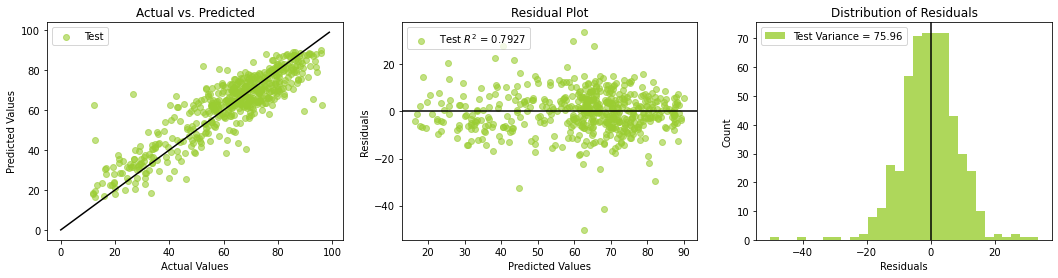

In [15]:
#Graph results
graph_residuals('ELA', 
            'All features',
            'Random Forest', 
            #ELA_train, 
            #ELA_train_pred_rf, 
            ELA_test, 
            ELA_test_pred_rf)

In [16]:
add_metrics('ELA', 
            'All features',
            'Random Forest', 
            #ELA_train, 
            #ELA_train_pred_rf, 
            ELA_test, 
            ELA_test_pred_rf)

In [17]:
metrics

,Subject,Features,Algorithm,Train r2,Train MAE,Train 95% Worst Case Error LB,Train 95% Worst Case Error UB,Test r2,Test MAE,Test 95% Worst Case Error LB,Test 95% Worst Case Error UB
0,ELA,All features,Linear Regression (baseline),0.799005,6.677475,-16.547091,17.187611,0.771052,6.948462,-18.039068,17.495580
1,Math,All features,Linear Regression (baseline),0.700370,9.679650,-22.831911,24.116995,0.655321,10.117124,-24.413786,23.483108
2,ELA,All features,Random Forest,NaN,NaN,NaN,NaN,0.792703,6.540850,-16.757434,14.956027


Our Random Forest model does seem to improve on our baseline Linear Regression model.  The MAE value is lower  by about 0.5 percentage points and the worst case lower bound and upper bound of residuals is a smaller intervval than those of our baseline.

<a id='section3.1.2'></a>
#### 3.1.2 LightGBM

<u>Target:</u> ELA Performance\
<u>Features:</u> All original features\
<u>Algorithm:</u> LightGBM

In [18]:
# Initiate LightGBM regressor
lg_ELA = lgb.LGBMRegressor(random_state = 16)

# Print out hyperparameters
print(lg_ELA.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 16, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [19]:
# Instantiate a k-fold CV random search object
rand_lg_ELA = RandomizedSearchCV(estimator=lg_ELA,
                                 param_distributions=params_lg,
                                 n_iter = 100,
                                 scoring=scoring,
                                 cv=3,
                                 verbose=1,
                                 n_jobs=1,
                                 random_state=16
                                )

# Fit train model
rand_lg_ELA.fit(X_train, ELA_train)

# Extract best hyperparameters
best_hyperparams = rand_lg_ELA.best_params_
print('Best hyerparameters:\n', best_hyperparams)

# Extract best model
best_lg_ELA = rand_lg_ELA.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best hyerparameters:
 {'reg_alpha': 0.2, 'num_leaves': 20, 'n_estimators': 100, 'min_child_samples': 10, 'max_depth': 60, 'learning_rate': 0.05}


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  4.9min finished


In [20]:
# Make predictions
#ELA_train_pred_lg = best_lg_ELA.predict(X_train)
ELA_test_pred_lg = best_lg_ELA.predict(X_test)

Graphs for
Target: ELA Performance
Features: All features
Algorithm: LightGBM


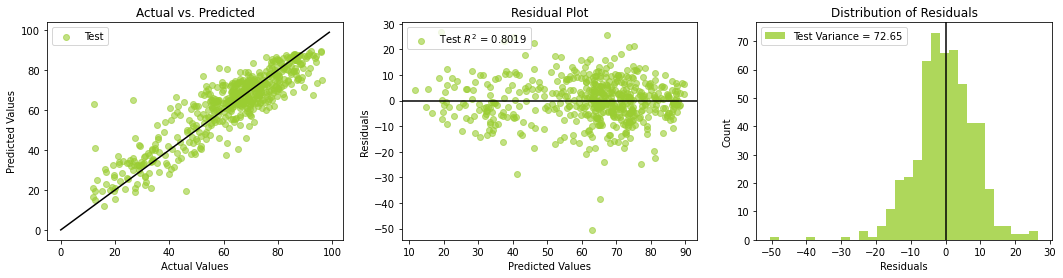

In [21]:
#Graph results
graph_residuals('ELA', 
                'All features',
                'LightGBM', 
                #ELA_train, 
                #ELA_train_pred_lg, 
                ELA_test, 
                ELA_test_pred_lg)

In [22]:
#add metrics
add_metrics('ELA', 
            'All features',
            'LightGBM', 
            #ELA_train, 
            #ELA_train_pred_lg, 
            ELA_test, 
            ELA_test_pred_lg)

In [23]:
metrics

,Subject,Features,Algorithm,Train r2,Train MAE,Train 95% Worst Case Error LB,Train 95% Worst Case Error UB,Test r2,Test MAE,Test 95% Worst Case Error LB,Test 95% Worst Case Error UB
0,ELA,All features,Linear Regression (baseline),0.799005,6.677475,-16.547091,17.187611,0.771052,6.948462,-18.039068,17.495580
1,Math,All features,Linear Regression (baseline),0.700370,9.679650,-22.831911,24.116995,0.655321,10.117124,-24.413786,23.483108
2,ELA,All features,Random Forest,NaN,NaN,NaN,NaN,0.792703,6.540850,-16.757434,14.956027
3,ELA,All features,LightGBM,NaN,NaN,NaN,NaN,0.801945,6.444087,-16.650741,15.755405


The LightGBM model is definitely also an improvement on our baseline.  The test performance is similar to our previous Random Forest model.

<a id='section3.1.3'></a>
#### 3.1.3 XGBoost

<u>Target:</u> ELA Performance\
<u>Features:</u> All original features\
<u>Algorithm:</u> XGBoost

In [24]:
# Initiate LightGBM regressor
xg_ELA = xgb.XGBRegressor(random_state = 16)

# Print out hyperparameters
print(xg_ELA.get_params())

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'enable_categorical': False, 'gamma': None, 'gpu_id': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_delta_step': None, 'max_depth': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 16, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [25]:
# Instantiate a k-fold CV random search object
rand_xg_ELA = RandomizedSearchCV(estimator=xg_ELA,
                                 param_distributions=params_xg,
                                 n_iter = 100,
                                 scoring=scoring,
                                 cv=3,
                                 verbose=1,
                                 n_jobs=1,
                                 random_state=16
                                )

# Fit train model
rand_xg_ELA.fit(X_train, ELA_train)

# Extract best hyperparameters
best_hyperparams = rand_xg_ELA.best_params_
print('Best hyerparameters:\n', best_hyperparams)

# Extract best model
best_xg_ELA = rand_xg_ELA.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  6.3min finished


Best hyerparameters:
 {'subsample': 0.5, 'n_estimators': 1000, 'min_child_weight': 10, 'max_depth': 90, 'learning_rate': 0.01, 'gamma': 10, 'colsample_bytree': 0.4}


In [26]:
# Make predictions
#ELA_train_pred_xg = best_xg_ELA.predict(X_train)
ELA_test_pred_xg = best_xg_ELA.predict(X_test)

Graphs for
Target: ELA Performance
Features: All features
Algorithm: XGBoost


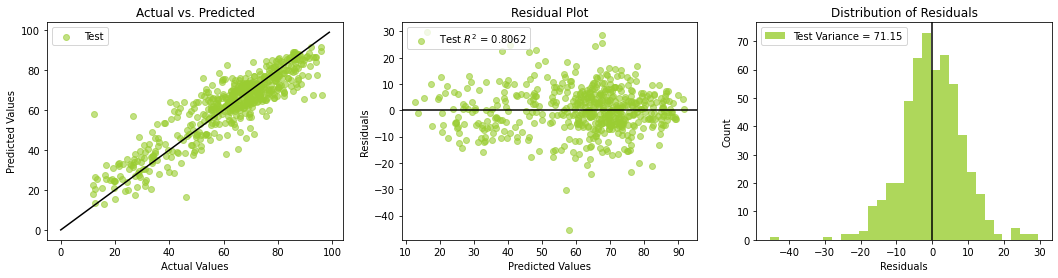

In [27]:
#Graph results
graph_residuals('ELA', 
            'All features',
            'XGBoost', 
            #ELA_train, 
            #ELA_train_pred_xg, 
            ELA_test, 
            ELA_test_pred_xg)

In [28]:
#add metrics
add_metrics('ELA', 
            'All features',
            'XGBoost', 
            #ELA_train, 
            #ELA_train_pred_xg, 
            ELA_test, 
            ELA_test_pred_xg)

In [29]:
metrics

,Subject,Features,Algorithm,Train r2,Train MAE,Train 95% Worst Case Error LB,Train 95% Worst Case Error UB,Test r2,Test MAE,Test 95% Worst Case Error LB,Test 95% Worst Case Error UB
0,ELA,All features,Linear Regression (baseline),0.799005,6.677475,-16.547091,17.187611,0.771052,6.948462,-18.039068,17.495580
1,Math,All features,Linear Regression (baseline),0.700370,9.679650,-22.831911,24.116995,0.655321,10.117124,-24.413786,23.483108
2,ELA,All features,Random Forest,NaN,NaN,NaN,NaN,0.792703,6.540850,-16.757434,14.956027
3,ELA,All features,LightGBM,NaN,NaN,NaN,NaN,0.801945,6.444087,-16.650741,15.755405
4,ELA,All features,XGBoost,NaN,NaN,NaN,NaN,0.806167,6.408681,-16.448528,15.871565


The XGBoost model seems to be similar to the LGBM and Random Forest models.  It does have <i>slightly</i> better metrics values than the other two models, with a higher $r^2$ score, lower MAE, and smaller interval for worst case lower and upper bound residuals.

<a id='section3.2'></a>
### 3.2 ELA - High correlation features removed

<a id='section3.2.1'></a>
#### 3.2.1 Random Forest

<u>Target:</u> ELA Performance\
<u>Features:</u> High correlation features removed\
<u>Algorithm:</u> Random Forest

In [30]:
# Instantiate a random forest regressor 
rf_ELA2 = RandomForestRegressor(random_state = 16)

# Print out hyperparameters
print(rf_ELA2.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 16, 'verbose': 0, 'warm_start': False}


In [31]:
# Instantiate a k-fold CV random search object
rand_rf_ELA2 = RandomizedSearchCV(estimator=rf_ELA2,
                                   param_distributions=params_rf,
                                   n_iter = 100,
                                   scoring=scoring,
                                   cv=3,
                                   verbose=1,
                                   n_jobs=1,
                                   random_state=16
                                )

# Fit train model
rand_rf_ELA2.fit(X_train2, ELA_train)
    
# Extract best hyperparameters
best_hyperparams = rand_rf_ELA2.best_params_
print('Best hyerparameters:\n', best_hyperparams)

# Extract best model
best_rf_ELA2 = rand_rf_ELA2.best_estimator_
    

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 14.5min finished


Best hyerparameters:
 {'n_estimators': 1000, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}


In [32]:
# Make predictions
#ELA2_train_pred_rf = best_rf_ELA2.predict(X_train2)
ELA2_test_pred_rf = best_rf_ELA2.predict(X_test2)

Graphs for
Target: ELA Performance
Features: High corr features removed
Algorithm: Random Forest


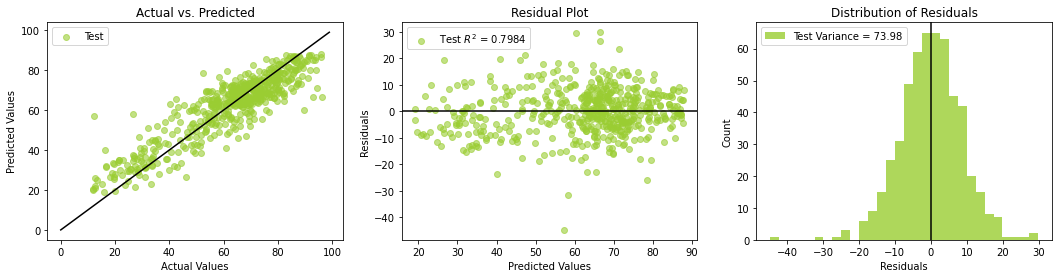

In [33]:
#Graph results
graph_residuals('ELA', 
                'High corr features removed',
                'Random Forest', 
                #ELA_train, 
                #ELA2_train_pred_rf, 
                ELA_test, 
                ELA2_test_pred_rf
               )

In [34]:
#add metrics to metrics table
add_metrics('ELA', 
            'High corr features removed',
            'Random Forest', 
            #ELA_train, 
            #ELA2_train_pred_rf, 
            ELA_test, 
            ELA2_test_pred_rf
            )

In [35]:
metrics

,Subject,Features,Algorithm,Train r2,Train MAE,Train 95% Worst Case Error LB,Train 95% Worst Case Error UB,Test r2,Test MAE,Test 95% Worst Case Error LB,Test 95% Worst Case Error UB
0,ELA,All features,Linear Regression (baseline),0.799005,6.677475,-16.547091,17.187611,0.771052,6.948462,-18.039068,17.495580
1,Math,All features,Linear Regression (baseline),0.700370,9.679650,-22.831911,24.116995,0.655321,10.117124,-24.413786,23.483108
2,ELA,All features,Random Forest,NaN,NaN,NaN,NaN,0.792703,6.540850,-16.757434,14.956027
3,ELA,All features,LightGBM,NaN,NaN,NaN,NaN,0.801945,6.444087,-16.650741,15.755405
4,ELA,All features,XGBoost,NaN,NaN,NaN,NaN,0.806167,6.408681,-16.448528,15.871565
5,ELA,High corr features removed,Random Forest,NaN,NaN,NaN,NaN,0.798437,6.614020,-16.460128,15.613353


Running the random forest model on the data with high correlation features removed shows that the performance is quite similar to the previos random forest model with all features included.  On the test set, this model produced a higher $r^2$ score, a higher MAE, and a larger interval for worst case lower and upper bounds compared to the original random forest model.  That being said, the difference is almost negligible.

<a id='section3.2.2'></a>
#### 3.2.2 LightGBM

<u>Target:</u> ELA Performance\
<u>Features:</u> High correlation features removed\
<u>Algorithm:</u> LightGBM

In [36]:
# Initiate LightGBM regressor
lg_ELA2 = lgb.LGBMRegressor(random_state = 16)

# Print out hyperparameters
print(lg_ELA2.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 16, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [37]:
# Instantiate a k-fold CV random search object
rand_lg_ELA2 = RandomizedSearchCV(estimator=lg_ELA2,
                                 param_distributions=params_lg,
                                 n_iter = 100,
                                 scoring=scoring,
                                 cv=3,
                                 verbose=1,
                                 n_jobs=1,
                                 random_state=16
                                )

# Fit train model
rand_lg_ELA2.fit(X_train2, ELA_train)

# Extract best hyperparameters
best_hyperparams = rand_lg_ELA2.best_params_
print('Best hyerparameters:\n', best_hyperparams)

# Extract best model
best_lg_ELA2 = rand_lg_ELA2.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best hyerparameters:
 {'reg_alpha': 0.2, 'num_leaves': 40, 'n_estimators': 100, 'min_child_samples': 5, 'max_depth': 80, 'learning_rate': 0.05}


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  3.8min finished


In [38]:
# Make predictions
#ELA2_train_pred_lg = best_lg_ELA2.predict(X_train2)
ELA2_test_pred_lg = best_lg_ELA2.predict(X_test2)

Graphs for
Target: ELA Performance
Features: High corr features removed
Algorithm: LightGBM


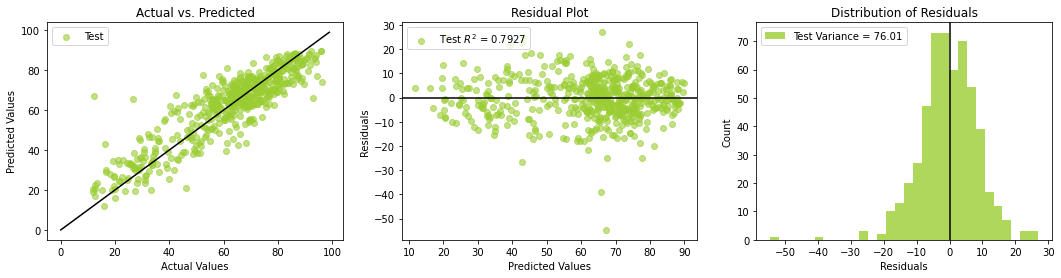

In [39]:
#Graph results
graph_residuals('ELA', 
                'High corr features removed',
                'LightGBM', 
                #ELA_train, 
                #ELA2_train_pred_lg, 
                ELA_test, 
                ELA2_test_pred_lg)

In [40]:
add_metrics('ELA', 
            'High corr features removed',
            'LightGBM', 
            #ELA_train, 
            #ELA2_train_pred_lg, 
            ELA_test, 
            ELA2_test_pred_lg)

In [41]:
metrics

,Subject,Features,Algorithm,Train r2,Train MAE,Train 95% Worst Case Error LB,Train 95% Worst Case Error UB,Test r2,Test MAE,Test 95% Worst Case Error LB,Test 95% Worst Case Error UB
0,ELA,All features,Linear Regression (baseline),0.799005,6.677475,-16.547091,17.187611,0.771052,6.948462,-18.039068,17.495580
1,Math,All features,Linear Regression (baseline),0.700370,9.679650,-22.831911,24.116995,0.655321,10.117124,-24.413786,23.483108
2,ELA,All features,Random Forest,NaN,NaN,NaN,NaN,0.792703,6.540850,-16.757434,14.956027
3,ELA,All features,LightGBM,NaN,NaN,NaN,NaN,0.801945,6.444087,-16.650741,15.755405
4,ELA,All features,XGBoost,NaN,NaN,NaN,NaN,0.806167,6.408681,-16.448528,15.871565
5,ELA,High corr features removed,Random Forest,NaN,NaN,NaN,NaN,0.798437,6.614020,-16.460128,15.613353
6,ELA,High corr features removed,LightGBM,NaN,NaN,NaN,NaN,0.792678,6.652352,-16.909029,15.794854


Running the LightGBM model with our high correlation features removed, we see that it performs slightly worse than the previous LightGBM model with all features included. On the test set, this model produced a slightly lower $r^2$ score, a higher MAE, and a larger interval for worst case lower and upper bounds compared to the original LightGBM model.

<a id='section3.2.3'></a>
#### 3.2.3 XGBoost

<u>Target:</u> ELA Performance\
<u>Features:</u> High correlation features removed\
<u>Algorithm:</u> XGBoost

In [42]:
# Initiate LightGBM regressor
xg_ELA2 = xgb.XGBRegressor(random_state = 16)

# Print out hyperparameters
print(xg_ELA2.get_params())

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'enable_categorical': False, 'gamma': None, 'gpu_id': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_delta_step': None, 'max_depth': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 16, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [43]:
# Instantiate a k-fold CV random search object
rand_xg_ELA2 = RandomizedSearchCV(estimator=xg_ELA2,
                                 param_distributions=params_xg,
                                 n_iter = 100,
                                 scoring=scoring,
                                 cv=3,
                                 verbose=1,
                                 n_jobs=1,
                                 random_state=16
                                )

# Fit train model
rand_xg_ELA2.fit(X_train2, ELA_train)

# Extract best hyperparameters
best_hyperparams = rand_xg_ELA2.best_params_
print('Best hyerparameters:\n', best_hyperparams)

# Extract best model
best_xg_ELA2 = rand_xg_ELA2.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  5.5min finished


Best hyerparameters:
 {'subsample': 0.4, 'n_estimators': 1000, 'min_child_weight': 6, 'max_depth': 20, 'learning_rate': 0.01, 'gamma': 10, 'colsample_bytree': 0.9}


In [44]:
# Make predictions
#ELA2_train_pred_xg = best_xg_ELA2.predict(X_train2)
ELA2_test_pred_xg = best_xg_ELA2.predict(X_test2)

Graphs for
Target: ELA Performance
Features: High corr features removed
Algorithm: XGBoost


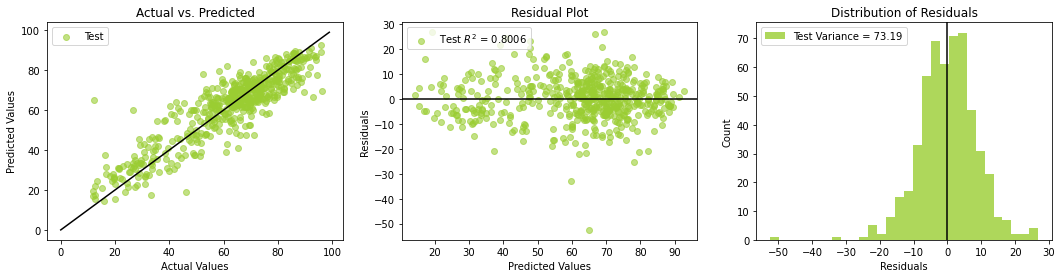

In [45]:
#Graph results
graph_residuals('ELA', 
                'High corr features removed',
                'XGBoost', 
                #ELA_train, 
                #ELA2_train_pred_xg, 
                ELA_test, 
                ELA2_test_pred_xg)

In [46]:
add_metrics('ELA', 
            'High corr features removed',
            'XGBoost', 
            #ELA_train, 
            #ELA2_train_pred_xg, 
            ELA_test, 
            ELA2_test_pred_xg)

In [47]:
metrics

,Subject,Features,Algorithm,Train r2,Train MAE,Train 95% Worst Case Error LB,Train 95% Worst Case Error UB,Test r2,Test MAE,Test 95% Worst Case Error LB,Test 95% Worst Case Error UB
0,ELA,All features,Linear Regression (baseline),0.799005,6.677475,-16.547091,17.187611,0.771052,6.948462,-18.039068,17.495580
1,Math,All features,Linear Regression (baseline),0.700370,9.679650,-22.831911,24.116995,0.655321,10.117124,-24.413786,23.483108
2,ELA,All features,Random Forest,NaN,NaN,NaN,NaN,0.792703,6.540850,-16.757434,14.956027
3,ELA,All features,LightGBM,NaN,NaN,NaN,NaN,0.801945,6.444087,-16.650741,15.755405
4,ELA,All features,XGBoost,NaN,NaN,NaN,NaN,0.806167,6.408681,-16.448528,15.871565
5,ELA,High corr features removed,Random Forest,NaN,NaN,NaN,NaN,0.798437,6.614020,-16.460128,15.613353
6,ELA,High corr features removed,LightGBM,NaN,NaN,NaN,NaN,0.792678,6.652352,-16.909029,15.794854
7,ELA,High corr features removed,XGBoost,NaN,NaN,NaN,NaN,0.800601,6.484040,-16.613331,17.044295


When we run our XGBoost model with high correlation features removed, it performs slightly worse than the previous XGBoost model with all features included.  On the test set, this model produced a slightly lower $r^2$ score, a higher MAE, and a larger interval for worst case lower and upper bounds compared to the original XGBoost model. 

We'll look at the comparison of models for school performance in ELA towards the end of this notebook.  Next we will train and test models for school performance in Math.

<a id='section4'></a>
## 4. Models for School Performance in Math

<a id='section4.1'></a>
### 4.1 Math - All original features

<a id='section4.1.1'></a>
#### 4.1.1 Random Forest

<u>Target:</u> Math Performance\
<u>Features:</u> All original features\
<u>Algorithm:</u> Random Forest

In [48]:
# Instantiate a random forest regressor 
rf_math = RandomForestRegressor(random_state = 16)

# Print out hyperparameters
print(rf_math.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 16, 'verbose': 0, 'warm_start': False}


In [49]:
# Instantiate a k-fold CV random search object
rand_rf_math = RandomizedSearchCV(estimator=rf_math,
                                   param_distributions=params_rf,
                                   n_iter = 100,
                                   scoring=scoring,
                                   cv=3,
                                   verbose=1,
                                   n_jobs=1,
                                   random_state=16
                                )

# Fit train model
rand_rf_math.fit(X_train, math_train)
    
# Extract best hyperparameters
best_hyperparams = rand_rf_math.best_params_
print('Best hyerparameters:\n', best_hyperparams)

# Extract best model
best_rf_math = rand_rf_math.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 19.5min finished


Best hyerparameters:
 {'n_estimators': 1000, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 100}


In [50]:
# Make predictions
#math_train_pred_rf = best_rf_math.predict(X_train)
math_test_pred_rf = best_rf_math.predict(X_test)

Graphs for
Target: Math Performance
Features: All features
Algorithm: Random Forest


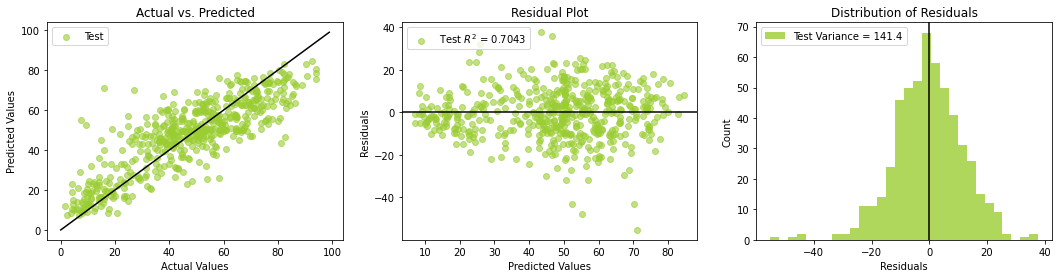

In [51]:
#Graph results
graph_residuals('Math', 
                'All features',
                'Random Forest', 
                #math_train, 
                #math_train_pred_rf, 
                math_test, 
                math_test_pred_rf)

In [52]:
add_metrics('Math', 
            'All features',
            'Random Forest', 
            #math_train, 
            #math_train_pred_rf, 
            math_test, 
            math_test_pred_rf)

In [53]:
metrics

,Subject,Features,Algorithm,Train r2,Train MAE,Train 95% Worst Case Error LB,Train 95% Worst Case Error UB,Test r2,Test MAE,Test 95% Worst Case Error LB,Test 95% Worst Case Error UB
0,ELA,All features,Linear Regression (baseline),0.799005,6.677475,-16.547091,17.187611,0.771052,6.948462,-18.039068,17.495580
1,Math,All features,Linear Regression (baseline),0.700370,9.679650,-22.831911,24.116995,0.655321,10.117124,-24.413786,23.483108
2,ELA,All features,Random Forest,NaN,NaN,NaN,NaN,0.792703,6.540850,-16.757434,14.956027
3,ELA,All features,LightGBM,NaN,NaN,NaN,NaN,0.801945,6.444087,-16.650741,15.755405
4,ELA,All features,XGBoost,NaN,NaN,NaN,NaN,0.806167,6.408681,-16.448528,15.871565
5,ELA,High corr features removed,Random Forest,NaN,NaN,NaN,NaN,0.798437,6.614020,-16.460128,15.613353
6,ELA,High corr features removed,LightGBM,NaN,NaN,NaN,NaN,0.792678,6.652352,-16.909029,15.794854
7,ELA,High corr features removed,XGBoost,NaN,NaN,NaN,NaN,0.800601,6.484040,-16.613331,17.044295
8,Math,All features,Random Forest,NaN,NaN,NaN,NaN,0.704263,9.139749,-22.957004,22.360568


Our first model for school performance in Math (Random Forest with all features included) is definitely an improvement already on our baseline.

<a id='section4.1.2'></a>
#### 4.1.2 LightGBM

<u>Target:</u> Math Performance\
<u>Features:</u> All original features\
<u>Algorithm:</u> LightGBM

In [54]:
# Initiate LightGBM regressor
lg_math = lgb.LGBMRegressor(random_state = 16)

# Print out hyperparameters
print(lg_math.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 16, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [55]:
# Instantiate a k-fold CV random search object
rand_lg_math = RandomizedSearchCV(estimator=lg_math,
                                 param_distributions=params_lg,
                                 n_iter = 100,
                                 scoring=scoring,
                                 cv=3,
                                 verbose=1,
                                 n_jobs=1,
                                 random_state=16
                                )

# Fit train model
rand_lg_math.fit(X_train, math_train)

# Extract best hyperparameters
best_hyperparams = rand_lg_math.best_params_
print('Best hyerparameters:\n', best_hyperparams)

# Extract best model
best_lg_math = rand_lg_math.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best hyerparameters:
 {'reg_alpha': 0.2, 'num_leaves': 20, 'n_estimators': 100, 'min_child_samples': 10, 'max_depth': 70, 'learning_rate': 0.1}


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  4.4min finished


In [56]:
# Make predictions
#math_train_pred_lg = best_lg_math.predict(X_train)
math_test_pred_lg = best_lg_math.predict(X_test)

Graphs for
Target: Math Performance
Features: All features
Algorithm: LightGBM


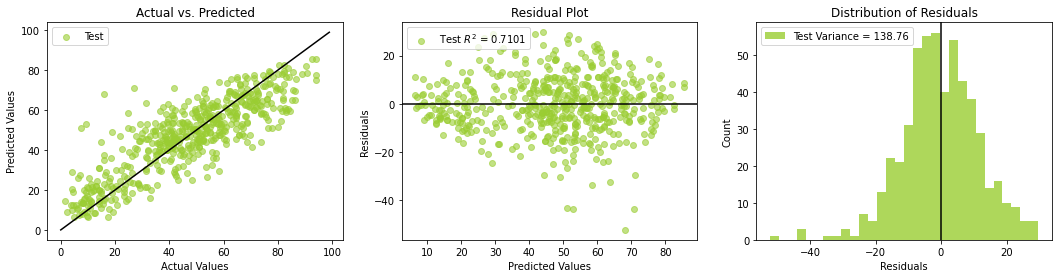

In [57]:
#Graph results
graph_residuals('Math', 
                'All features',
                'LightGBM', 
                #math_train, 
                #math_train_pred_lg, 
                math_test, 
                math_test_pred_lg)

In [58]:
#add metrics
add_metrics('Math', 
            'All features',
            'LightGBM', 
            #math_train, 
            #math_train_pred_lg, 
            math_test, 
            math_test_pred_lg)

In [59]:
metrics

,Subject,Features,Algorithm,Train r2,Train MAE,Train 95% Worst Case Error LB,Train 95% Worst Case Error UB,Test r2,Test MAE,Test 95% Worst Case Error LB,Test 95% Worst Case Error UB
0,ELA,All features,Linear Regression (baseline),0.799005,6.677475,-16.547091,17.187611,0.771052,6.948462,-18.039068,17.495580
1,Math,All features,Linear Regression (baseline),0.700370,9.679650,-22.831911,24.116995,0.655321,10.117124,-24.413786,23.483108
2,ELA,All features,Random Forest,NaN,NaN,NaN,NaN,0.792703,6.540850,-16.757434,14.956027
3,ELA,All features,LightGBM,NaN,NaN,NaN,NaN,0.801945,6.444087,-16.650741,15.755405
4,ELA,All features,XGBoost,NaN,NaN,NaN,NaN,0.806167,6.408681,-16.448528,15.871565
5,ELA,High corr features removed,Random Forest,NaN,NaN,NaN,NaN,0.798437,6.614020,-16.460128,15.613353
6,ELA,High corr features removed,LightGBM,NaN,NaN,NaN,NaN,0.792678,6.652352,-16.909029,15.794854
7,ELA,High corr features removed,XGBoost,NaN,NaN,NaN,NaN,0.800601,6.484040,-16.613331,17.044295
8,Math,All features,Random Forest,NaN,NaN,NaN,NaN,0.704263,9.139749,-22.957004,22.360568
9,Math,All features,LightGBM,NaN,NaN,NaN,NaN,0.710077,9.103636,-23.904595,23.129591


The LightGBM model performs similar to the previous random forest model.  It does have a higher $r^2$ score and a lower MAE, but the interval for worst case lower and upper bounds of residuals is slightly larger.

<a id='section4.1.3'></a>
#### 4.1.3 XGBoost

<u>Target:</u> Math Performance\
<u>Features:</u> All original features\
<u>Algorithm:</u> XGBoost

In [60]:
# Initiate LightGBM regressor
xg_math = xgb.XGBRegressor(random_state = 16)

# Print out hyperparameters
print(xg_math.get_params())

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'enable_categorical': False, 'gamma': None, 'gpu_id': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_delta_step': None, 'max_depth': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 16, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [61]:
# Instantiate a k-fold CV random search object
rand_xg_math = RandomizedSearchCV(estimator=xg_math,
                                 param_distributions=params_xg,
                                 n_iter = 100,
                                 scoring=scoring,
                                 cv=3,
                                 verbose=1,
                                 n_jobs=1,
                                 random_state=16
                                )

# Fit train model
rand_xg_math.fit(X_train, math_train)

# Extract best hyperparameters
best_hyperparams = rand_xg_math.best_params_
print('Best hyerparameters:\n', best_hyperparams)

# Extract best model
best_xg_math = rand_xg_math.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  6.6min finished


Best hyerparameters:
 {'subsample': 0.4, 'n_estimators': 1000, 'min_child_weight': 6, 'max_depth': 20, 'learning_rate': 0.01, 'gamma': 10, 'colsample_bytree': 0.9}


In [62]:
# Make predictions
#math_train_pred_xg = best_xg_math.predict(X_train)
math_test_pred_xg = best_xg_math.predict(X_test)

Graphs for
Target: Math Performance
Features: All features
Algorithm: XGBoost


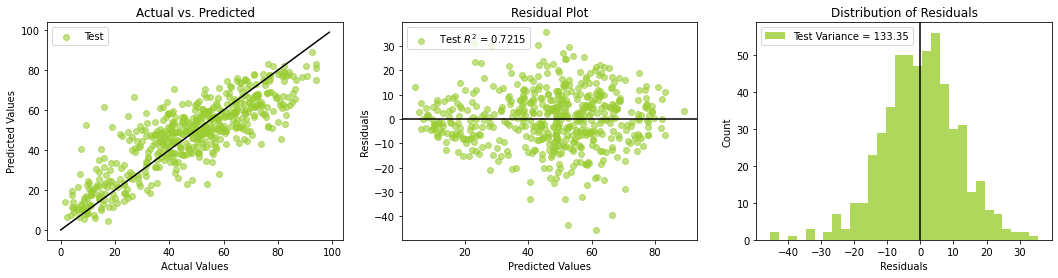

In [63]:
#Graph results
graph_residuals('Math', 
                'All features',
                'XGBoost', 
                #math_train, 
                #math_train_pred_xg, 
                math_test, 
                math_test_pred_xg)

In [64]:
#add metrics
add_metrics('Math', 
            'All features',
            'XGBoost', 
            #math_train, 
            #math_train_pred_xg, 
            math_test, 
            math_test_pred_xg)

In [65]:
metrics

,Subject,Features,Algorithm,Train r2,Train MAE,Train 95% Worst Case Error LB,Train 95% Worst Case Error UB,Test r2,Test MAE,Test 95% Worst Case Error LB,Test 95% Worst Case Error UB
0,ELA,All features,Linear Regression (baseline),0.799005,6.677475,-16.547091,17.187611,0.771052,6.948462,-18.039068,17.495580
1,Math,All features,Linear Regression (baseline),0.700370,9.679650,-22.831911,24.116995,0.655321,10.117124,-24.413786,23.483108
2,ELA,All features,Random Forest,NaN,NaN,NaN,NaN,0.792703,6.540850,-16.757434,14.956027
3,ELA,All features,LightGBM,NaN,NaN,NaN,NaN,0.801945,6.444087,-16.650741,15.755405
4,ELA,All features,XGBoost,NaN,NaN,NaN,NaN,0.806167,6.408681,-16.448528,15.871565
5,ELA,High corr features removed,Random Forest,NaN,NaN,NaN,NaN,0.798437,6.614020,-16.460128,15.613353
6,ELA,High corr features removed,LightGBM,NaN,NaN,NaN,NaN,0.792678,6.652352,-16.909029,15.794854
7,ELA,High corr features removed,XGBoost,NaN,NaN,NaN,NaN,0.800601,6.484040,-16.613331,17.044295
8,Math,All features,Random Forest,NaN,NaN,NaN,NaN,0.704263,9.139749,-22.957004,22.360568
9,Math,All features,LightGBM,NaN,NaN,NaN,NaN,0.710077,9.103636,-23.904595,23.129591


When modeling our math school performance target variable with XGBoost, it performs similar if not slightly better than our previous two models.  The $r^2$ score is higher, MAE is lower, but the interval for worst case lower and upper bounds of residuals is slightly larger than the Random Forest model.

<a id='section4.2'></a>
### 4.2 Math - High correlation features removed

<a id='section4.2.1'></a>
#### 4.2.1 Random Forest

<u>Target:</u> Math Performance\
<u>Features:</u> High correlation features removed\
<u>Algorithm:</u> Random Forest

In [66]:
# Instantiate a random forest regressor 
rf_math2 = RandomForestRegressor(random_state = 16)

# Print out hyperparameters
print(rf_math2.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 16, 'verbose': 0, 'warm_start': False}


In [67]:
# Instantiate a k-fold CV random search object
rand_rf_math2 = RandomizedSearchCV(estimator=rf_math2,
                                   param_distributions=params_rf,
                                   n_iter = 100,
                                   scoring=scoring,
                                   cv=3,
                                   verbose=1,
                                   n_jobs=1,
                                   random_state=16
                                )

# Fit train model
rand_rf_math2.fit(X_train2, math_train)
    
# Extract best hyperparameters
best_hyperparams = rand_rf_math2.best_params_
print('Best hyerparameters:\n', best_hyperparams)

# Extract best model
best_rf_math2 = rand_rf_math2.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 14.3min finished


Best hyerparameters:
 {'n_estimators': 1000, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 100}


In [68]:
# Make predictions
#math2_train_pred_rf = best_rf_math2.predict(X_train2)
math2_test_pred_rf = best_rf_math2.predict(X_test2)

Graphs for
Target: Math Performance
Features: High corr features removed
Algorithm: Random Forest


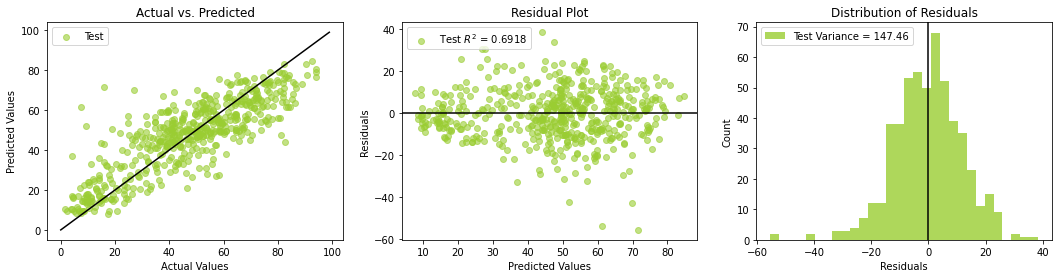

In [69]:
#Graph results
graph_residuals('Math', 
                'High corr features removed',
                'Random Forest', 
                #math_train, 
                #math2_train_pred_rf, 
                math_test, 
                math2_test_pred_rf
               )

In [70]:
#add metrics to metrics table
add_metrics('Math', 
            'High corr features removed',
            'Random Forest', 
            #math_train, 
            #math2_train_pred_rf, 
            math_test, 
            math2_test_pred_rf
            )

In [71]:
metrics

,Subject,Features,Algorithm,Train r2,Train MAE,Train 95% Worst Case Error LB,Train 95% Worst Case Error UB,Test r2,Test MAE,Test 95% Worst Case Error LB,Test 95% Worst Case Error UB
0,ELA,All features,Linear Regression (baseline),0.799005,6.677475,-16.547091,17.187611,0.771052,6.948462,-18.039068,17.495580
1,Math,All features,Linear Regression (baseline),0.700370,9.679650,-22.831911,24.116995,0.655321,10.117124,-24.413786,23.483108
2,ELA,All features,Random Forest,NaN,NaN,NaN,NaN,0.792703,6.540850,-16.757434,14.956027
3,ELA,All features,LightGBM,NaN,NaN,NaN,NaN,0.801945,6.444087,-16.650741,15.755405
4,ELA,All features,XGBoost,NaN,NaN,NaN,NaN,0.806167,6.408681,-16.448528,15.871565
5,ELA,High corr features removed,Random Forest,NaN,NaN,NaN,NaN,0.798437,6.614020,-16.460128,15.613353
6,ELA,High corr features removed,LightGBM,NaN,NaN,NaN,NaN,0.792678,6.652352,-16.909029,15.794854
7,ELA,High corr features removed,XGBoost,NaN,NaN,NaN,NaN,0.800601,6.484040,-16.613331,17.044295
8,Math,All features,Random Forest,NaN,NaN,NaN,NaN,0.704263,9.139749,-22.957004,22.360568
9,Math,All features,LightGBM,NaN,NaN,NaN,NaN,0.710077,9.103636,-23.904595,23.129591


In comparison to the original Random Forest model for math using all original features, this random forest model performs just slightly worse.  The test $r^2$ score is slightly lower, while the MAE is slightly larger and the upper and lower bounds of the worst case residuals are wider.

<a id='section4.2.2'></a>
#### 4.2.2 LightGBM

<u>Target:</u> Math Performance\
<u>Features:</u> High correlation features removed\
<u>Algorithm:</u> LightGBM

In [72]:
# Initiate LightGBM regressor
lg_math2 = lgb.LGBMRegressor(random_state = 16)

# Print out hyperparameters
print(lg_math2.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 16, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [73]:
# Instantiate a k-fold CV random search object
rand_lg_math2 = RandomizedSearchCV(estimator=lg_math2,
                                 param_distributions=params_lg,
                                 n_iter = 100,
                                 scoring=scoring,
                                 cv=3,
                                 verbose=1,
                                 n_jobs=1,
                                 random_state=16
                                )

# Fit train model
rand_lg_math2.fit(X_train2, math_train)

# Extract best hyperparameters
best_hyperparams = rand_lg_math2.best_params_
print('Best hyerparameters:\n', best_hyperparams)

# Extract best model
best_lg_math2 = rand_lg_math2.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best hyerparameters:
 {'reg_alpha': 0.2, 'num_leaves': 40, 'n_estimators': 100, 'min_child_samples': 5, 'max_depth': 80, 'learning_rate': 0.05}


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  3.8min finished


In [74]:
# Make predictions
#math2_train_pred_lg = best_lg_math2.predict(X_train2)
math2_test_pred_lg = best_lg_math2.predict(X_test2)

Graphs for
Target: Math Performance
Features: High corr features removed
Algorithm: LightGBM


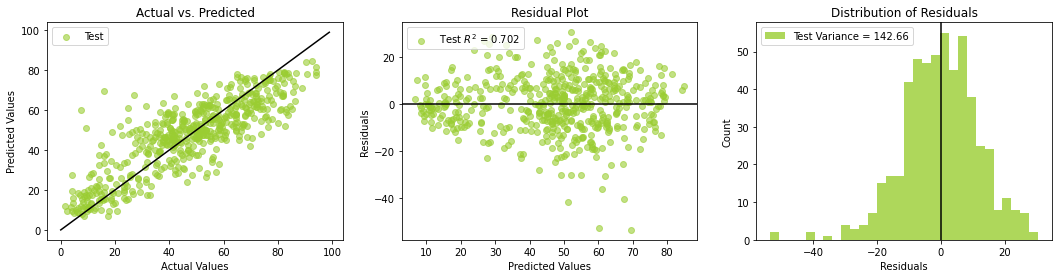

In [75]:
#Graph results
graph_residuals('Math', 
                'High corr features removed',
                'LightGBM', 
                #math_train, 
                #math2_train_pred_lg, 
                math_test, 
                math2_test_pred_lg)

In [76]:
add_metrics('Math', 
            'High corr features removed',
            'LightGBM', 
            #math_train, 
            #math2_train_pred_lg, 
            math_test, 
            math2_test_pred_lg)

In [77]:
metrics

,Subject,Features,Algorithm,Train r2,Train MAE,Train 95% Worst Case Error LB,Train 95% Worst Case Error UB,Test r2,Test MAE,Test 95% Worst Case Error LB,Test 95% Worst Case Error UB
0,ELA,All features,Linear Regression (baseline),0.799005,6.677475,-16.547091,17.187611,0.771052,6.948462,-18.039068,17.495580
1,Math,All features,Linear Regression (baseline),0.700370,9.679650,-22.831911,24.116995,0.655321,10.117124,-24.413786,23.483108
2,ELA,All features,Random Forest,NaN,NaN,NaN,NaN,0.792703,6.540850,-16.757434,14.956027
3,ELA,All features,LightGBM,NaN,NaN,NaN,NaN,0.801945,6.444087,-16.650741,15.755405
4,ELA,All features,XGBoost,NaN,NaN,NaN,NaN,0.806167,6.408681,-16.448528,15.871565
5,ELA,High corr features removed,Random Forest,NaN,NaN,NaN,NaN,0.798437,6.614020,-16.460128,15.613353
6,ELA,High corr features removed,LightGBM,NaN,NaN,NaN,NaN,0.792678,6.652352,-16.909029,15.794854
7,ELA,High corr features removed,XGBoost,NaN,NaN,NaN,NaN,0.800601,6.484040,-16.613331,17.044295
8,Math,All features,Random Forest,NaN,NaN,NaN,NaN,0.704263,9.139749,-22.957004,22.360568
9,Math,All features,LightGBM,NaN,NaN,NaN,NaN,0.710077,9.103636,-23.904595,23.129591


Our LightGBM model for math performance with the high correlation features removed also performs slightly worse than the original LightGBM model.  The test $r^2$ score is lower and the MAE is larger.

<a id='section4.2.3'></a>
#### 4.2.3 XGBoost

<u>Target:</u> Math Performance\
<u>Features:</u> High correlation features removed\
<u>Algorithm:</u> XGBoost

In [78]:
# Initiate XGBoost regressor
xg_math2 = xgb.XGBRegressor(random_state = 16)

# Print out hyperparameters
print(xg_math2.get_params())

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'enable_categorical': False, 'gamma': None, 'gpu_id': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_delta_step': None, 'max_depth': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 16, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [79]:
# Instantiate a k-fold CV random search object
rand_xg_math2 = RandomizedSearchCV(estimator=xg_math2,
                                 param_distributions=params_xg,
                                 n_iter = 100,
                                 scoring=scoring,
                                 cv=3,
                                 verbose=1,
                                 n_jobs=1,
                                 random_state=16
                                )

# Fit train model
rand_xg_math2.fit(X_train2, math_train)

# Extract best hyperparameters
best_hyperparams = rand_xg_math2.best_params_
print('Best hyerparameters:\n', best_hyperparams)

# Extract best model
best_xg_math2 = rand_xg_math2.best_estimator_



Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  5.6min finished


Best hyerparameters:
 {'subsample': 0.4, 'n_estimators': 1000, 'min_child_weight': 6, 'max_depth': 20, 'learning_rate': 0.01, 'gamma': 10, 'colsample_bytree': 0.9}


In [80]:
# Make predictions
#math2_train_pred_xg = best_xg_math2.predict(X_train2)
math2_test_pred_xg = best_xg_math2.predict(X_test2)

Graphs for
Target: Math Performance
Features: High corr features removed
Algorithm: XGBoost


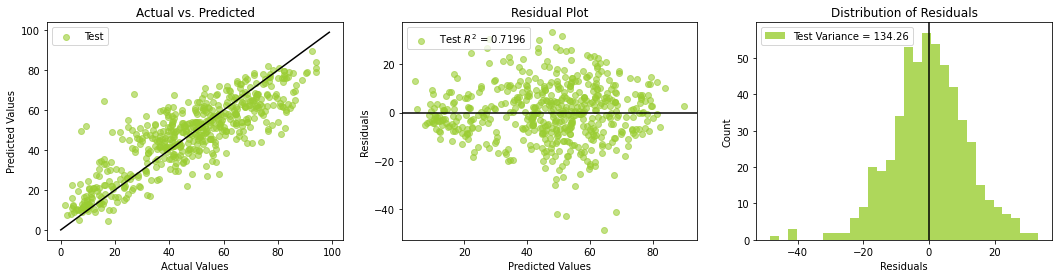

In [81]:
#Graph results
graph_residuals('Math', 
                'High corr features removed',
                'XGBoost', 
                #math_train, 
                #math2_train_pred_xg, 
                math_test, 
                math2_test_pred_xg)

In [82]:
add_metrics('Math', 
            'High corr features removed',
            'XGBoost', 
            #math_train, 
            #math2_train_pred_xg, 
            math_test, 
            math2_test_pred_xg)

In [83]:
metrics

,Subject,Features,Algorithm,Train r2,Train MAE,Train 95% Worst Case Error LB,Train 95% Worst Case Error UB,Test r2,Test MAE,Test 95% Worst Case Error LB,Test 95% Worst Case Error UB
0,ELA,All features,Linear Regression (baseline),0.799005,6.677475,-16.547091,17.187611,0.771052,6.948462,-18.039068,17.495580
1,Math,All features,Linear Regression (baseline),0.700370,9.679650,-22.831911,24.116995,0.655321,10.117124,-24.413786,23.483108
2,ELA,All features,Random Forest,NaN,NaN,NaN,NaN,0.792703,6.540850,-16.757434,14.956027
3,ELA,All features,LightGBM,NaN,NaN,NaN,NaN,0.801945,6.444087,-16.650741,15.755405
4,ELA,All features,XGBoost,NaN,NaN,NaN,NaN,0.806167,6.408681,-16.448528,15.871565
5,ELA,High corr features removed,Random Forest,NaN,NaN,NaN,NaN,0.798437,6.614020,-16.460128,15.613353
6,ELA,High corr features removed,LightGBM,NaN,NaN,NaN,NaN,0.792678,6.652352,-16.909029,15.794854
7,ELA,High corr features removed,XGBoost,NaN,NaN,NaN,NaN,0.800601,6.484040,-16.613331,17.044295
8,Math,All features,Random Forest,NaN,NaN,NaN,NaN,0.704263,9.139749,-22.957004,22.360568
9,Math,All features,LightGBM,NaN,NaN,NaN,NaN,0.710077,9.103636,-23.904595,23.129591


When removing high correlation features from our dataset, the XGBoost model performs slightly worse for math than its original counterpart with all features included. The test $r^2$ score is lower, but the the MAE is lower.

<a id='section5'></a>
## 5. Model Selection

In order to better understand our table of metrics and compare the scores, we'll generate separate bar plots for each metric to compare how the models scored.

In [84]:
#create a copy of our metrics dataframe
metrics2 = metrics

#add a column for 'Model', combining the Algorithm with the feature type
metrics2['Model'] = metrics2['Algorithm'] + ' with ' + metrics2['Features']

<a id='section5.1'></a>
### 5.1 ELA Model Selection

We'll create new tables for each of our three metrics so that we can easily graph them.

In [85]:
#melt metrics2 dataframe to create r2 table
metrics_ELA_r2 = metrics2[metrics2['Subject']=='ELA'].melt(id_vars=['Model'], 
                                                           value_vars=['Test r2'],
                                                           var_name = 'Type',
                                                           value_name = 'r2')

#replace values in 'Type' column
metrics_ELA_r2["Type"].replace({"Test r2": "Test"}, inplace=True)

In [86]:
#melt metrics2 dataframe to create MAE table
metrics_ELA_MAE = metrics2[metrics2['Subject']=='ELA'].melt(id_vars=['Model'], 
                                                            value_vars=['Test MAE'],
                                                            var_name = 'Type',
                                                            value_name = 'MAE'
                                                           )
#replace values in 'Type' column
metrics_ELA_MAE["Type"].replace({"Test MAE": "Test"}, inplace=True)

In [87]:
#melt metrics2 dataframe to create table for worst case residuals
metrics_ELA_res = metrics2[metrics2['Subject']=='ELA'].melt(id_vars=['Model'], 
                                                            value_vars=['Test 95% Worst Case Error LB',
                                                                        'Test 95% Worst Case Error UB'],
                                                            var_name = 'Type',
                                                            value_name = 'Worst Case'
                                                           )
#replace values in 'Type' column
metrics_ELA_res["Type"].replace({'Test 95% Worst Case Error LB':'Test',
                                 'Test 95% Worst Case Error UB':'Test'
                                }, 
                                inplace=True)

We'll start by comparing the $r^2$ score of all the models.  

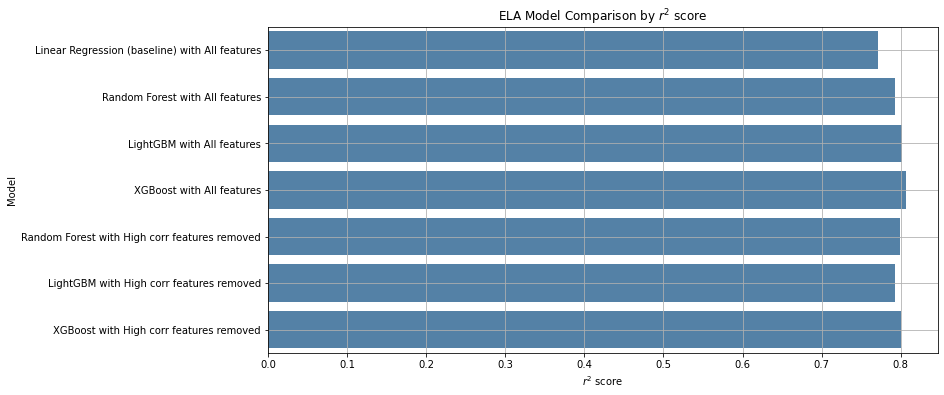

In [95]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x = 'r2', y = 'Model', data = metrics_ELA_r2, color = 'steelblue')
ax.set_xlabel('$r^2$ score')
ax.set_title('ELA Model Comparison by $r^2$ score')
plt.grid()
plt.show()

Next we'll compare the Mean Absolute Error of our models.

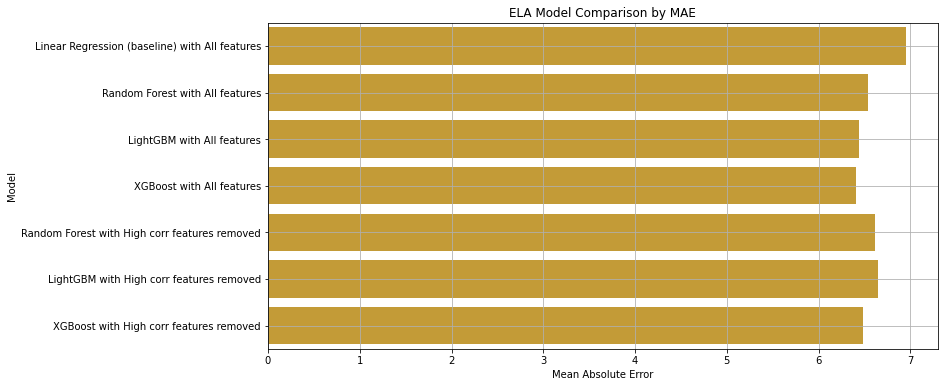

In [102]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x = 'MAE', y = 'Model', data = metrics_ELA_MAE, color = 'goldenrod')
ax.set_xlabel('Mean Absolute Error')
ax.set_title('ELA Model Comparison by MAE')
plt.grid()
plt.show()

And finally we'll compare the worst case upper and lower bounds of our residuals.

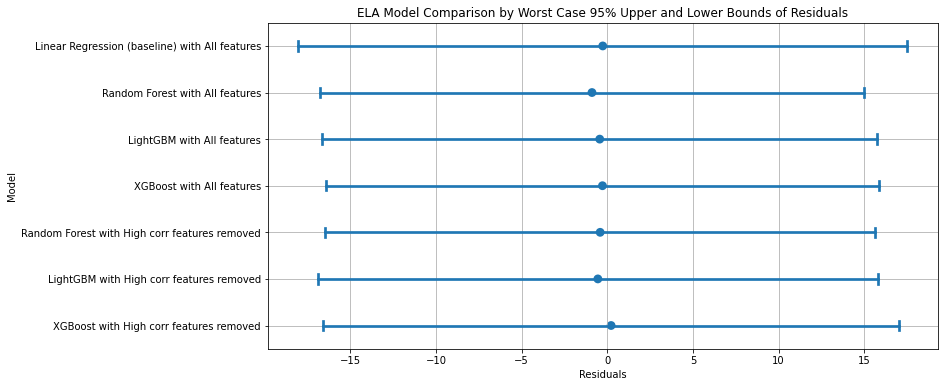

In [91]:
plt.figure(figsize=(12,6))

ax = sns.pointplot(x = 'Worst Case', 
                   y='Model',  
                   data = metrics_ELA_res, 
                   dodge=0.2, 
                   join=False,
                   capsize=0.2
                  )

ax.set_xlabel('Residuals')
ax.set_title('ELA Model Comparison by Worst Case 95% Upper and Lower Bounds of Residuals')
plt.grid()
plt.show()

There is no clear winner amoung our models for predicting school performance in ELA.  All of our 6 models improve on our baseline linear regression model, and their metrics have negligible differences.

While there may be other choices that are more ideal in other settings, for the purpose of moving forward with interpretability analysis for this project we will select the <b>XGBoost</b> algorithm with the <b>all features included</b>.  This model has the highest $r^2$ score and the lowest MAE score out of the models we tested.  

For reference, here are the graphs of the results and metrics from this model.

Graphs for
Target: ELA Performance
Features: All features included
Algorithm: XGBoost


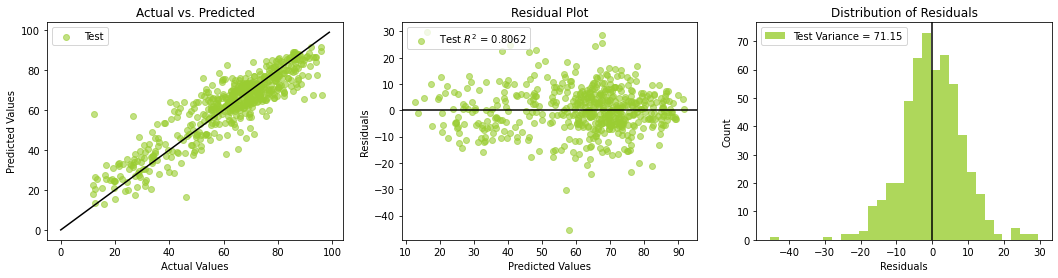

In [103]:
#Graph results
graph_residuals('ELA', 
                'All features included',
                'XGBoost',  
                ELA_test, 
                ELA_test_pred_xg)

In [114]:
metrics.iloc[4]

Subject                                                ELA
Features                                      All features
Algorithm                                          XGBoost
Train r2                                               NaN
Train MAE                                              NaN
Train 95% Worst Case Error LB                          NaN
Train 95% Worst Case Error UB                          NaN
Test r2                                           0.806167
Test MAE                                           6.40868
Test 95% Worst Case Error LB                      -16.4485
Test 95% Worst Case Error UB                       15.8716
Model                            XGBoost with All features
Name: 4, dtype: object

<a id='section5.2'></a>
### 5.1 Math Model Selection

We'll create new tables for each of our three metrics so that we can easily graph them.

In [105]:
#melt metrics2 dataframe to create r2 table
metrics_math_r2 = metrics2[metrics2['Subject']=='Math'].melt(id_vars=['Model'], 
                                                           value_vars=['Test r2'],
                                                           var_name = 'Type',
                                                           value_name = 'r2')

#replace values in 'Type' column
metrics_math_r2["Type"].replace({"Test r2": "Test"}, inplace=True)

In [107]:
#melt metrics2 dataframe to create MAE table
metrics_math_MAE = metrics2[metrics2['Subject']=='Math'].melt(id_vars=['Model'], 
                                                            value_vars=['Test MAE'],
                                                            var_name = 'Type',
                                                            value_name = 'MAE'
                                                           )
#replace values in 'Type' column
metrics_math_MAE["Type"].replace({"Test MAE": "Test"}, inplace=True)

In [108]:
#melt metrics2 dataframe to create table for worst case residuals
metrics_math_res = metrics2[metrics2['Subject']=='Math'].melt(id_vars=['Model'], 
                                                            value_vars=['Test 95% Worst Case Error LB',
                                                                        'Test 95% Worst Case Error UB'],
                                                            var_name = 'Type',
                                                            value_name = 'Worst Case'
                                                           )
#replace values in 'Type' column
metrics_math_res["Type"].replace({'Test 95% Worst Case Error LB':'Test',
                                 'Test 95% Worst Case Error UB':'Test'
                                }, 
                                inplace=True)

We'll start by comparing the $r^2$ score of all the models.  

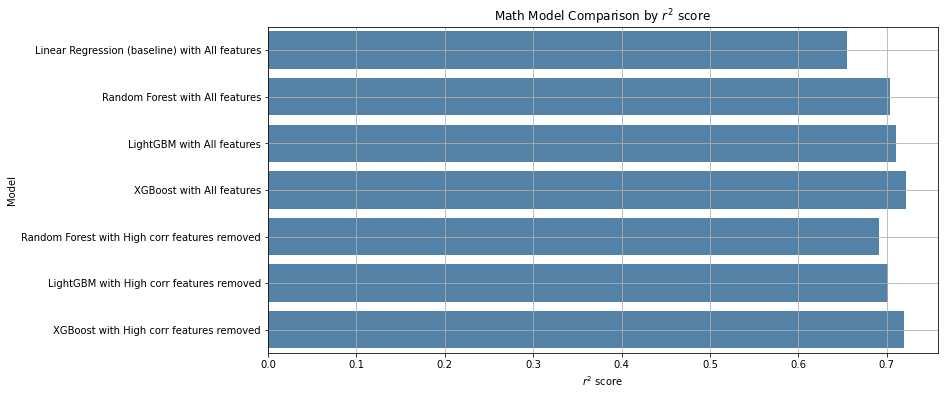

In [109]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x = 'r2', y = 'Model', data = metrics_math_r2, color = 'steelblue')
ax.set_xlabel('$r^2$ score')
ax.set_title('Math Model Comparison by $r^2$ score')
plt.grid()
plt.show()

Next we'll compare the Mean Absolute Error of our models.

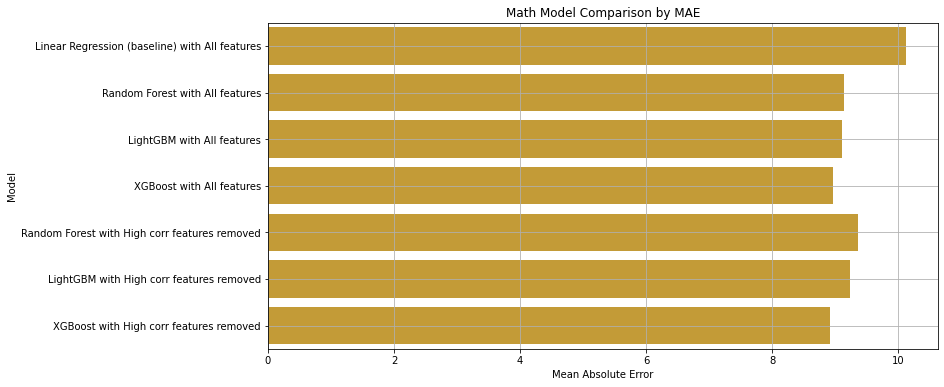

In [110]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x = 'MAE', y = 'Model', data = metrics_math_MAE, color = 'goldenrod')
ax.set_xlabel('Mean Absolute Error')
ax.set_title('Math Model Comparison by MAE')
plt.grid()
plt.show()

And finally we'll compare the worst case upper and lower bounds of our residuals.

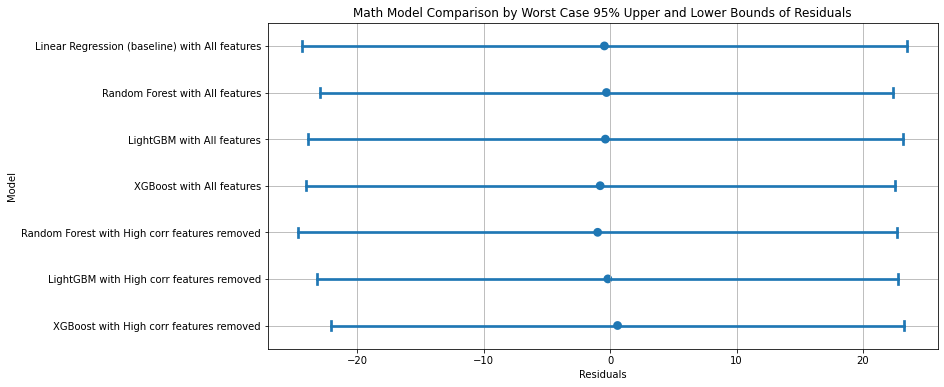

In [111]:
plt.figure(figsize=(12,6))

ax = sns.pointplot(x = 'Worst Case', 
                   y='Model', 
                   data = metrics_math_res, 
                   dodge=0.2, 
                   join=False,
                   capsize=0.2
                  )

ax.set_xlabel('Residuals')
ax.set_title('Math Model Comparison by Worst Case 95% Upper and Lower Bounds of Residuals')
plt.grid()
plt.show()

As was the case for our ELA models, there is no clear winner among our models for predicting school performance in math.  

With that said, for the purpose of moving forward with interpretability analysis for this project, we will select the <b>XGBoost</b> algorithm with the <b>high correlation features removed</b>.  

This model produced the the second highest test $r^2$ score (second to the XGBoost model with all features included), the lowest test MAE, and the smallest test interval for worst case upper and lower bounds of residuals.

For reference, here are the graphs of the results and metrics from this model.

Graphs for
Target: Math Performance
Features: High corr features removed
Algorithm: XGBoost


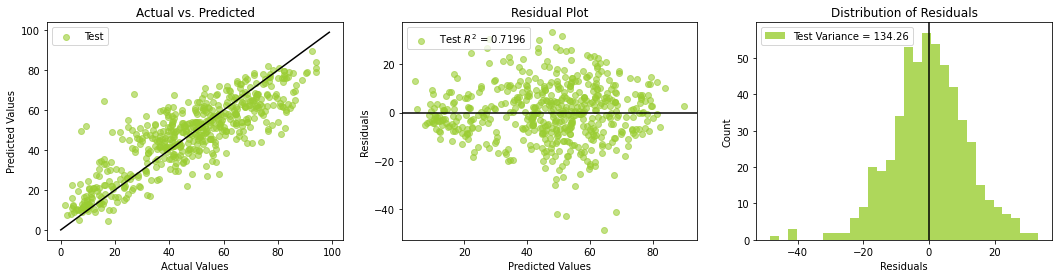

In [112]:
#Graph results
graph_residuals('Math', 
                'High corr features removed',
                'XGBoost', 
                math_test, 
                math2_test_pred_xg)

In [113]:
metrics.iloc[13]

Subject                                                             Math
Features                                      High corr features removed
Algorithm                                                        XGBoost
Train r2                                                             NaN
Train MAE                                                            NaN
Train 95% Worst Case Error LB                                        NaN
Train 95% Worst Case Error UB                                        NaN
Test r2                                                         0.719577
Test MAE                                                         8.91189
Test 95% Worst Case Error LB                                    -22.0896
Test 95% Worst Case Error UB                                     23.2412
Model                            XGBoost with High corr features removed
Name: 13, dtype: object

<a id='section6'></a>
## 6. Feature Impact

To better understand how each of our features impact our model's predictions, we'll use the SHAP package.  The SHAP package will take our model and train set and produce what are called SHAP values for each feature of each row of data.  For each row and feature in our dataset, the SHAP value represent the impact that that specific feature has on the overall value of the model's output.  To put it another way, the sum of the SHAP values for all the features added with the average prediction for the whole dataset must equal the value of the target.

We can use the shap summary beeswarm plots, combined with color, to understand how high/low values of features can positively or negatively impact our target variable.

In [115]:
import shap

<a id='section6.1'></a>
### 6.1 ELA School Performance Model

In [129]:
explainer_ELA = shap.TreeExplainer(best_xg_ELA)
shap_values_ELA = explainer_ELA.shap_values(X=X_train)

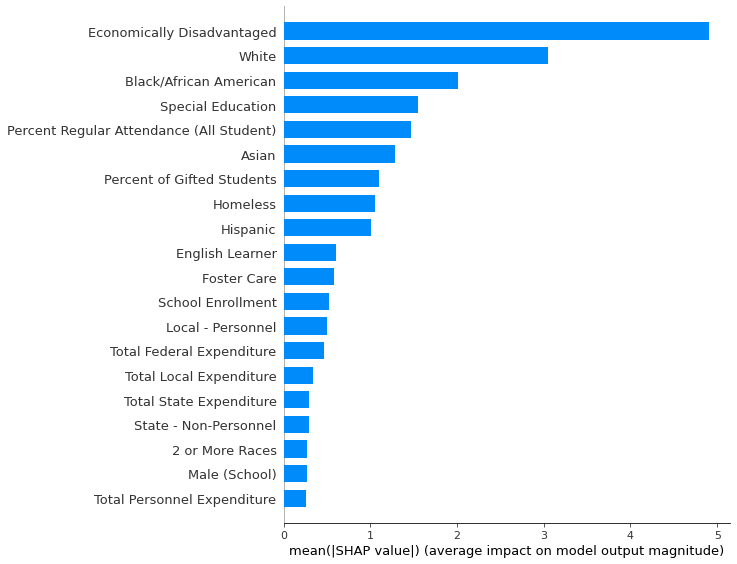

In [130]:
shap.summary_plot(shap_values_ELA, X_train, plot_type="bar", feature_names = cols.tolist())

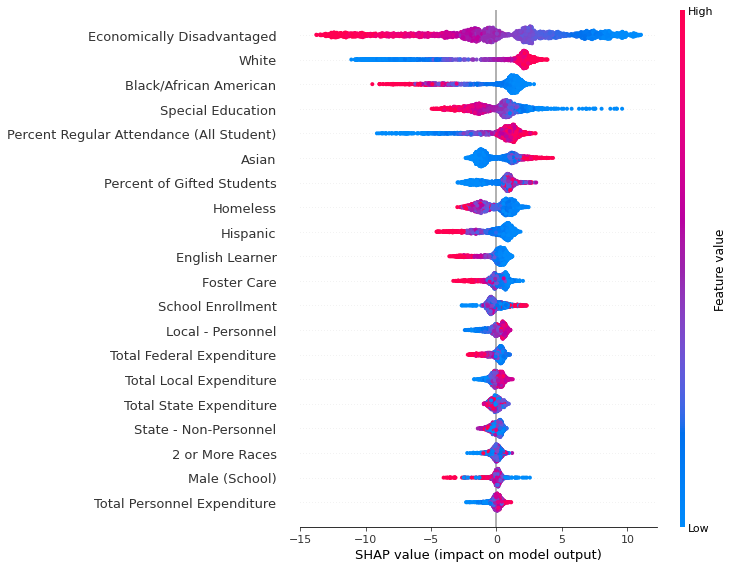

In [131]:
shap.summary_plot(shap_values_ELA, X_train, feature_names = cols.tolist(), show=False)
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)

Our SHAP summary plots show interesting trends for our models predicting school performance in ELA.  The top 5 most important features based on the averages of the magnitude of the impact are as follows.  The definitions from the data dictionary are also included.

1. <b>Economically Disadvantaged</b> - The percent of students who are considered economically disadvantaged in the school based on October Student Snapshot enrollment equals the number of students identified as economically disadvantaged in the school divided by total school enrollment. 
2. <b>White</b> - The percent of White students in the school based on October Student Snapshot enrollment equals the number of White native students in the school divided by total school enrollment.
3. <b>Black/African American</b> - The percent of Black or African American (not Hispanic) students in the school based on October Student Snapshot enrollment equals the number of Black or African American (not Hispanic) native students in the school divided by total school enrollment.
4. <b>Special Education</b> - The percent of school-age students receiving special education services in the school based on the Special Education December collection and the October Student Snapshot enrollment equals the number of students receiving special education services divided by the total school enrollment.
5. <b>Percent Regular Attendance (All Student)</b> - This indicator is the percentage of students enrolled in a school for 90 or more school days and present 90 percent or more of these school days.

We can also translate the SHAP summary plots to explain how the features impact the model for ELA performance in a more intuitive way.

<u>Features that <i>positively</i> impact school performance in ELA:</u>
- Lower 'Economically Disadvantaged'
- Higher 'White'
- Lower 'Black/African American'
- Lower 'Special Education'
- Higher 'Percent Regular Attendance (All Student)'


<u>Features that <i>negatively</i> impact school performance in ELA:</u>
- Higher 'Economically Disadvantaged'
- Lower 'White'
- Higher 'Black/African American'
- Higher 'Special Education'
- Lower 'Percent Regular Attendance (All Student)'

We can also use SHAP dependence plots to show how not only how a feature impacts a target variable, but how another feature interacts with this feature.  The second feature is chosen automatically by the shap.dependence_plot function.

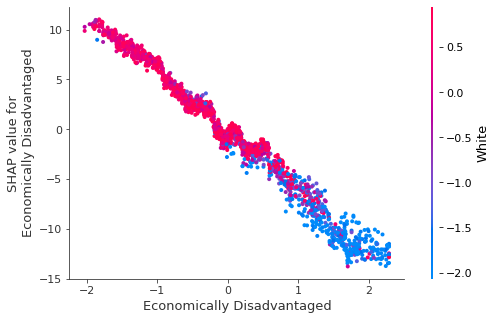

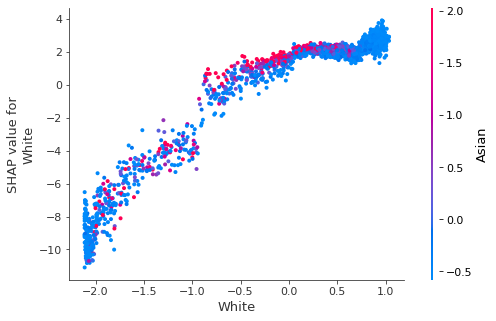

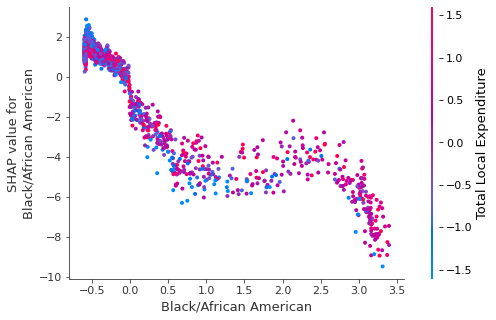

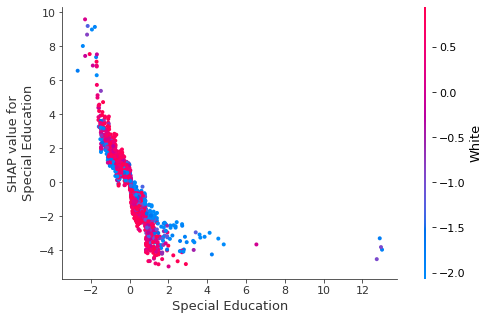

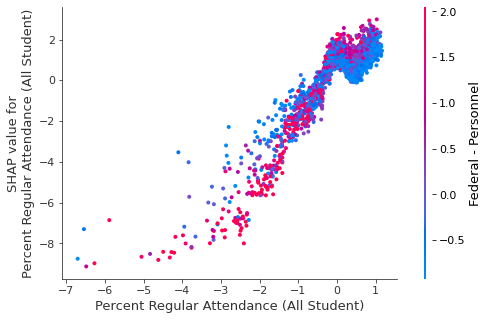

In [167]:
# produce dependence plots for top five features
shap.dependence_plot('Economically Disadvantaged', shap_values_ELA, pd.DataFrame(X_train, columns = cols))
shap.dependence_plot('White', shap_values_ELA, pd.DataFrame(X_train, columns = cols))
shap.dependence_plot('Black/African American', shap_values_ELA, pd.DataFrame(X_train, columns = cols))
shap.dependence_plot('Special Education', shap_values_ELA, pd.DataFrame(X_train, columns = cols))
shap.dependence_plot('Percent Regular Attendance (All Student)', shap_values_ELA, pd.DataFrame(X_train, columns = cols))

Our first graph shows the clearest pattern, indicating that low values of 'Economically Disadvantaged' tend to have high values of 'White' as well as a have a positive impact on the target.  Additionally, high values of 'Economically Disadvantaged tend to have low values of 'White' as well as a negative impact on the target.

From our second graph, we can see that low values of 'White' tend to have low values of 'Asian' and a negative impact on the target.  Additionally, high values of 'White' tened to have either high or low values of 'Asian' and a positive impact on the target.

And from our final graph, we can see that low values of 'Percent Regular Attendance' tend to have high values of 'Federal - Personnel' as well as a negative impact on the target.  Additionally, high values of 'Percent Regular Attendance' tend to have either high or low values of 'Federal - Personnel' as well as a positive impact on the target.  With that said, the magnitude of this positive impact is not as great as that of the negative impact.

<a id='section6.2'></a>
### 6.2 Math School Performance Model

In [123]:
explainer_math = shap.TreeExplainer(best_xg_math2)
shap_values_math = explainer_math.shap_values(X=X_train2)

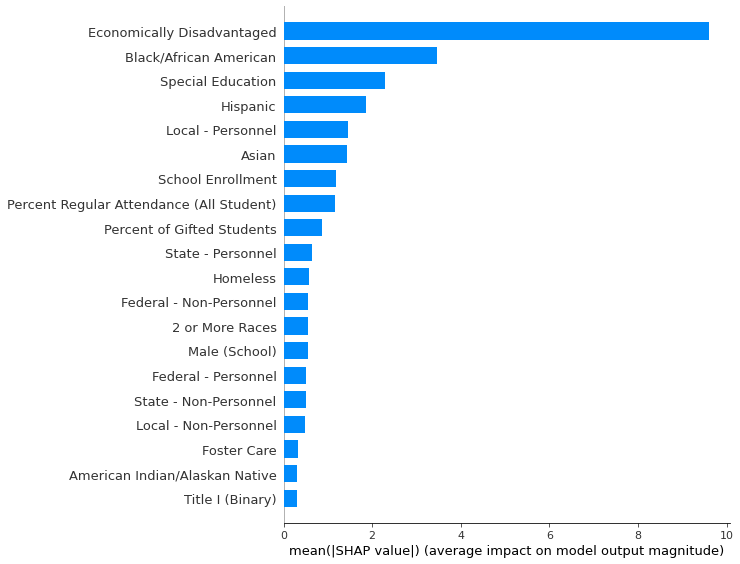

In [124]:
shap.summary_plot(shap_values_math, X_train2, plot_type="bar", feature_names = cols2.tolist())

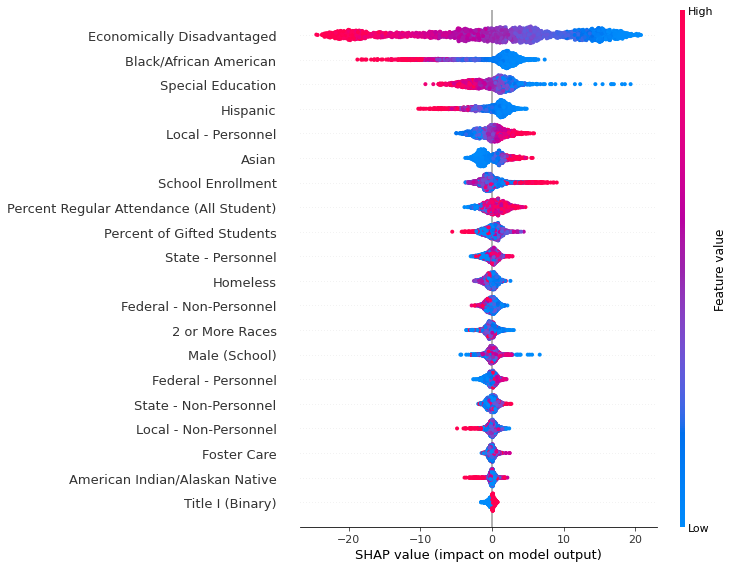

In [125]:
shap.summary_plot(shap_values_math, X_train2, feature_names = cols2.tolist(), show=False)
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)

Our SHAP summary plots for school performance in Math show similar trends as the model predicting school performance in ELA, but there are definitely a few noteworthy differences.  The top 5 most important features for school performance in Math based on the averages of the magnitude of the impact are as follows.  The definitions from the data dictionary are also included.

1. <b>Economically Disadvantaged</b> - The percent of students who are considered economically disadvantaged in the school based on October Student Snapshot enrollment equals the number of students identified as economically disadvantaged in the school divided by total school enrollment. 
2. <b>Black/African American</b> - The percent of Black or African American (not Hispanic) students in the school based on October Student Snapshot enrollment equals the number of Black or African American (not Hispanic) native students in the school divided by total school enrollment.
3. <b>Special Education</b> - The percent of school-age students receiving special education services in the school based on the Special Education December collection and the October Student Snapshot enrollment equals the number of students receiving special education services divided by the total school enrollment.
4. <b>Hispanic</b> - The percent of Hispanic students in the school based on October Student Snapshot enrollment equals the number of Hispanic native students in the school divided by total school enrollment.
5. <b>Local - Personnel</b> - The local amount spent per pupil for public elementary and secondary education (pre-K through 12th grade) on non-personnel.


We can also translate the SHAP summary plots to explain how the features impact the model for Math performance in a more intuitive way.

<u>Features that <i>positively</i> impact school performance in Math:</u>
- Lower 'Economically Disadvantaged'
- Lower 'Black/African American'
- Lower 'Special Education'
- Lower 'Hispanic'
- Higher 'Local - Personnel'
- Higher 'Percent Regular Attendance (All Student)'


<u>Features that <i>negatively</i> impact school performance in Math:</u>
- Higher 'Economically Disadvantaged'
- Higher 'Black/African American'
- Higher 'Special Education'
- Higher 'Hispanic'
- Lower 'Local - Personnel'
- Lower 'Percent Regular Attendance (All Student)'

As we did with our ELA model, we'll use SHAP dependence plots to show how a feature interacts with another feature to impact the target value.

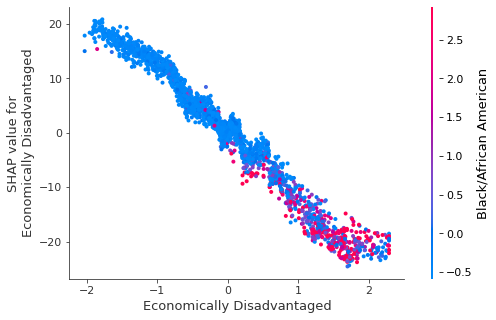

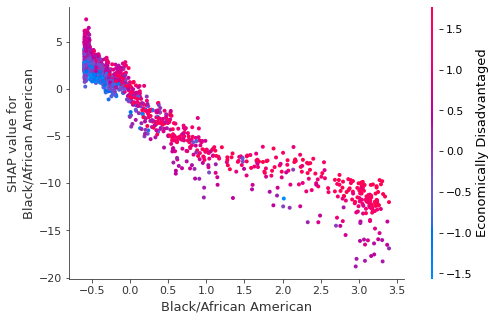

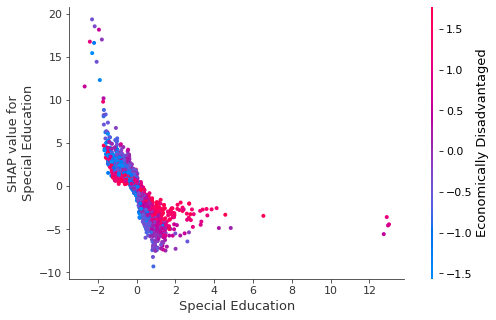

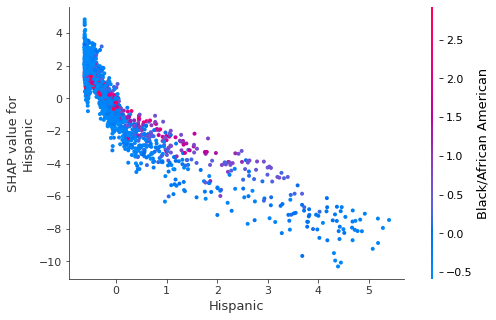

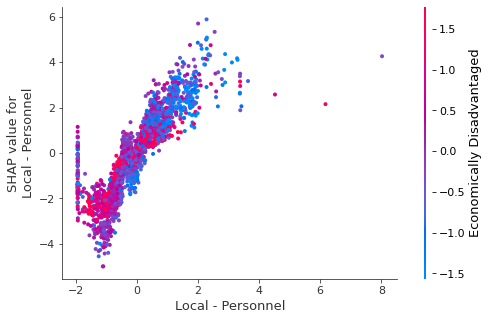

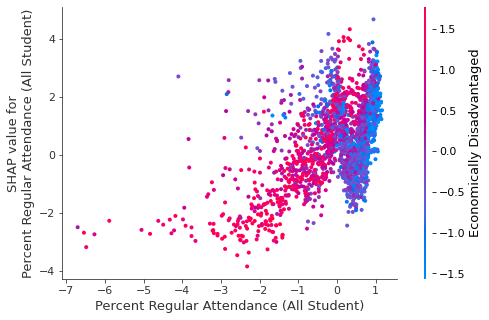

In [168]:
# produce dependence plots for top five features
shap.dependence_plot('Economically Disadvantaged', shap_values_math, pd.DataFrame(X_train2, columns = cols2))
shap.dependence_plot('Black/African American', shap_values_math, pd.DataFrame(X_train2, columns = cols2))
shap.dependence_plot('Special Education', shap_values_math, pd.DataFrame(X_train2, columns = cols2))
shap.dependence_plot('Hispanic', shap_values_math, pd.DataFrame(X_train2, columns = cols2))
shap.dependence_plot('Local - Personnel', shap_values_math, pd.DataFrame(X_train2, columns = cols2))
shap.dependence_plot('Percent Regular Attendance (All Student)', shap_values_math, pd.DataFrame(X_train2, columns = cols2))

For our math model, the first dependence plot shows that low values of 'Economically Disadvantaged' tend to have low values of 'Black/African American' and also have a positive impact on the target variable.  Higher values of 'Economically Disadvantaged' can have high or low values of 'Black/African American' and has a negative impact on the target.

Our second plot shows that higher values of 'Black/African American' tend to have higher values of 'Economically Disadvantaged' and also have a negative impact on the target.  Lower values of 'Black/African American' seem to have both high and low values of 'Economically Disadvantaged', as well as a positive impact on the target.

Our fifth plot shows that low values of 'Local - Personnel' tend to have low values of 'Economically Disadvantaged', as well as a negative impact on the target variable.  High values of 'Local - Personnel' seem to have a mixture of high and low values of 'Economically Disadvantaged', but mostly high, as well as a positive impact on the target variable.

Our sixth plot shows that as low values of 'Percent Regular Attendance' tend to have high values of 'Economically Disadvantaged' as well as a negative impact on the target.  High values of 'Percent Regular Attendance' seem to have a mixture of high/low values of 'Economically Disadvantaged' as well as a mixture of positive/negative impact on the target variable.

<a id='section6.3'></a>
### 6.3 Feature Impact Considerations

In preparation for counterfactual explanations, we need to assess which of these features have practical potential to be altered.  It does not make sense to adjust the racial demographic percentages of a school or number of special education, homeless, and foster care students, nor is it <i>ethical</i>, to increase or reduce the number of students from these categories purely to improve school performance. 

Assuming our clients for this project are state education law makers and school officials, it may be worth emphasizing the impact of the features 'Economically Disadvantaged' and 'Percent Regular Attendance (All Student)'.  Certainly, it is not feasible nor ethical to simply reduce the number of students that come from economically disadvantaged families (or increase the number of students that come from wealthier families).  However, an argument can be made for investing in the <i>local communities</i> of underperforming schools, providing support services to families whose income fall below the poverty threshold and perhaps even offering microloans to families with small businesses to expand. As for 'Percent Regular Attendance (All Student)', we can make a recommendation to our clients that increase efforts to encourage regular attendance, particularly in underperforming schools.  School officials can do this by reaching out to families and understanding the barriers of regular attendance.



What is also interesting and perhaps unexpected from our SHAP analysis is that <i>most</i> of our expenditure features do <i>not</i> have significant impact on school performance. Certainly this is true for our ELA model, as our expenditure variables are near the end of the list of features with highest impact.  For our math model, the only expenditure variable that may potentially have <i>some</i> significant impact is 'Local - Personnel'.  With that in mind, we are careful to mention the difference between correlation and causality in this situation.  We are witnessing that higher values of 'Local - Personnel' is <i>correlated</i> with higher values of school performance in Math.  This may be a result of a variety of reasons and may not necessarily imply causality. 

We can make the argument the problems of underperforming schools are not a result the issues within the school, but rather a result of issues in the community.  Further, the most effective solutions for improving school performance may not lie in simply increasing funding, but rather in connecting with the local communities of schools and improving the quality of life for struggling families. 

<a id='section7'></a>
## 7. Next steps

In our next notebook, we will analyze a school whose actual target values were 0 for both ELA and Math.  In other words, this school had 0% of students scoring proficient or above in both ELA and Math. We will provide counterfactual explanations to try to increase school performance to a predefined threshold.

Additionally, we will also discuss future work that can be done in this project.

In [169]:
#save ELA model
with open('../Models/ELA_model.pkl', 'wb') as f:
    pickle.dump(best_xg_ELA, f)

In [170]:
#save Math model
with open('../Models/math_model.pkl', 'wb') as f:
    pickle.dump(best_xg_math2, f)

In [171]:
#save input datasets (scaled and high correlation features removed)
pd.DataFrame(X_train2, columns = cols2).to_csv('../Data/X_train_scaled2.csv')
pd.DataFrame(X_test2, columns = cols2).to_csv('../Data/X_test_scaled2.csv')